In [1]:
import pyregion
from astropy.io import fits

In [2]:
fregion = "LAB.reg"

with open(fregion) as fin:
    region_string = fin.read()

In [56]:
import spectrum
fcube = "data/outcube_median_022.fits.gz"
s = spectrum.readSpectrum(fcube)
ww = s.grid()

In [57]:
r2 = pyregion.parse(region_string).as_imagecoord(s.hdu.header)
myfilter = r2.get_filter()

mask = r2.get_mask(shape=s.data[0])



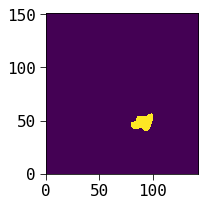

In [58]:
from matplotlib import pyplot as plt
% matplotlib inline
plt.subplot(121).imshow(mask, origin="lower", interpolation="nearest")


In [59]:
import numpy as np
sout = np.zeros( s.data.shape[0]  )
for i in range(s.data.shape[0]):
    sout[i] = np.sum( s.data[i][mask] )

In [60]:
def draw_line(wl, label):
    plt.text(wl,100.,label, rotation=90., ha='center', size=20, va='top')
    plt.plot([wl]*2,[0.,80.], c='r', lw=1.)

(3500.0, 5250.0)

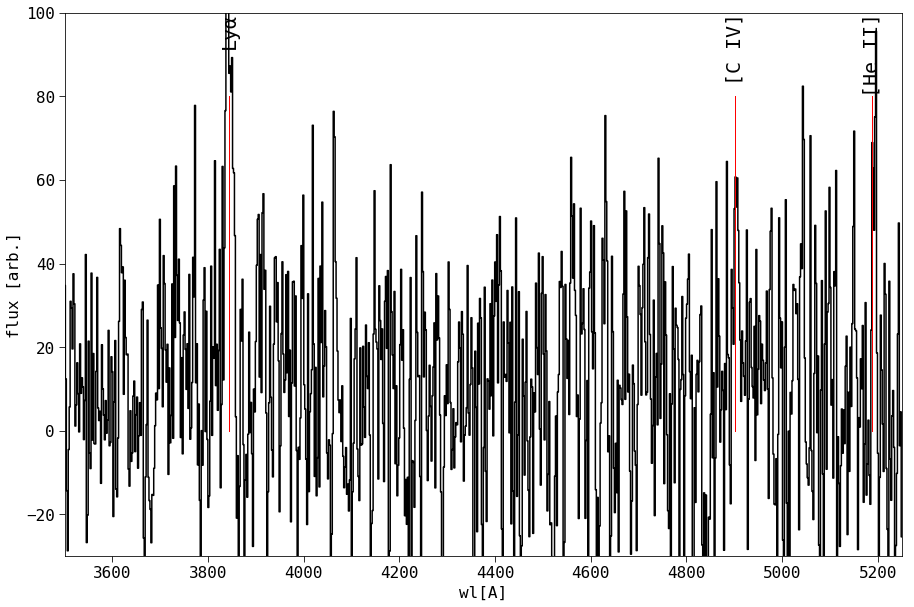

In [61]:
f = plt.figure(figsize = [15,10])
plt.plot(ww, sout, drawstyle='steps-mid')
plt.ylim([-30,100])
plt.xlabel("wl[A]")
plt.ylabel("flux [arb.]")

#If line 3844.0A is [Lyα         ] at rest. wl = 1215.2A (z = 2.163)
# Line 4906.7 could be [C IV        ] at rest wl. 1549.48, obs. wl = 4901.25A, dA = 5.45A
# Line 5193.4 could be [He II       ] at rest wl. 1640.4, obs. wl = 5188.85A, dA = 4.55A


draw_line(3844.0, "Lyα")
draw_line(4901.25, "[C IV]")
draw_line(5188.85, "[He II]")
plt.xlim([3500.,5250.])

#plt.xlim([-30,100])

In [62]:
from scipy.optimize import least_squares

import numpy as np

#generic gaussian
def gauss(mu, sigma, x):
    return 1./(sigma * np.sqrt(2. * np.pi) ) * np.exp( -(x-mu)**2./(2. * sigma**2.))

def peval(p,x):
    A,mu,sigma = p
    return A*gauss(mu, sigma, x)

def resid(p, x, y):
    model = peval(p,x)
    return (y - model)




(3500.0, 5250.0)

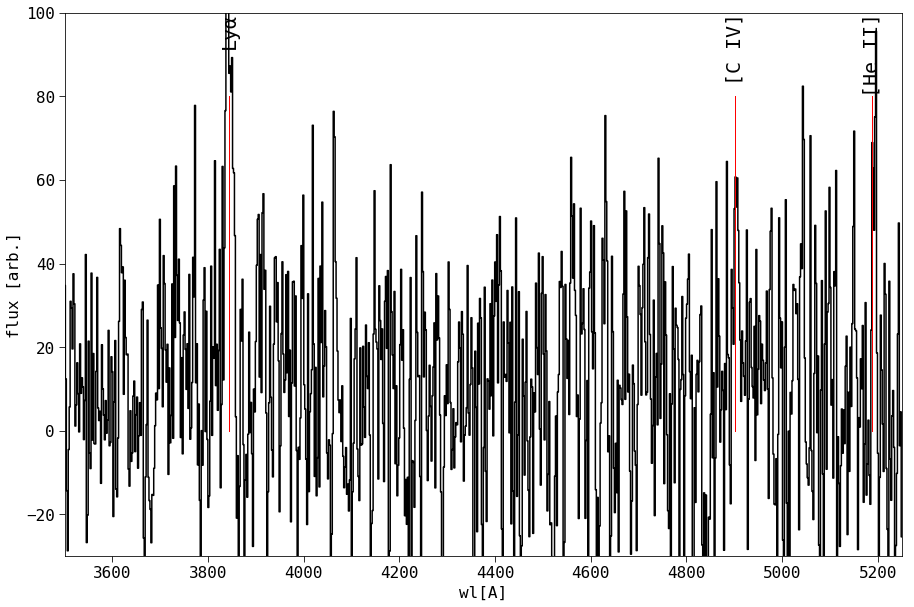

In [64]:



f = plt.figure(figsize = [15,10])
plt.plot(ww, sout, drawstyle='steps-mid')
plt.ylim([-30,100])
plt.xlabel("wl[A]")
plt.ylabel("flux [arb.]")

#If line 3844.0A is [Lyα         ] at rest. wl = 1215.2A (z = 2.163)
# Line 4906.7 could be [C IV        ] at rest wl. 1549.48, obs. wl = 4901.25A, dA = 5.45A
# Line 5193.4 could be [He II       ] at rest wl. 1640.4, obs. wl = 5188.85A, dA = 4.55A


draw_line(3844.0, "Lyα")
draw_line(4901.25, "[C IV]")
draw_line(5188.85, "[He II]")
plt.xlim([3500.,5250.])


(3500.0, 5250.0)

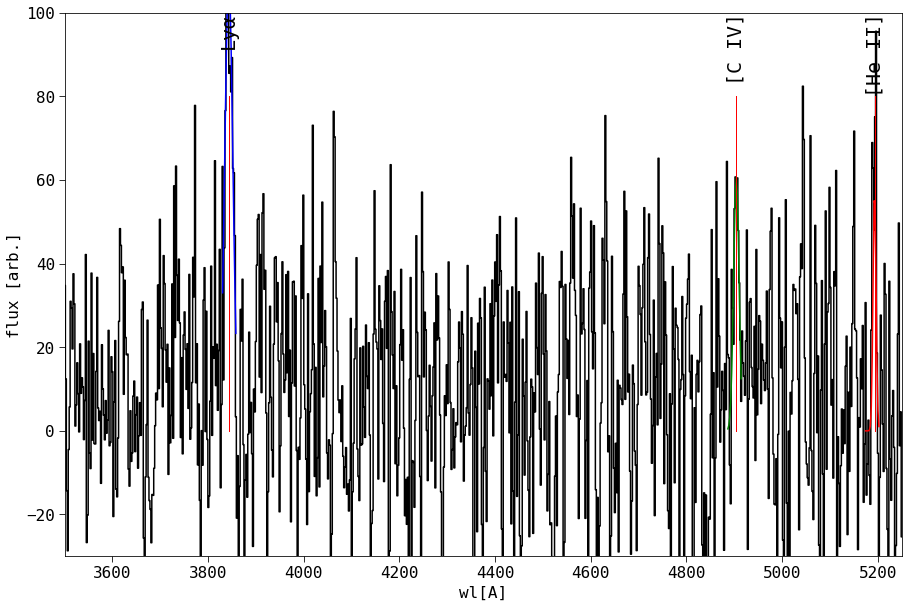

In [68]:
f = plt.figure(figsize = [15,10])
plt.plot(ww, sout, drawstyle='steps-mid')
plt.ylim([-30,100])
plt.xlabel("wl[A]")
plt.ylabel("flux [arb.]")


results = []
wlwin = 30.
for wlc in [3844.,4901.25, 5188.85]:
    #wlc = 3843.11
    p0 = [2000.,wlc,10.]
    ii = (ww > wlc-wlwin/2.) * (ww < wlc+wlwin/2.)
    fit = least_squares(resid, p0, args=(ww[ii], sout[ii]))
    p = fit.x
    plt.plot(ww[ii], peval(p,ww[ii]))
    results.append([p[1],p[2]])

#If line 3844.0A is [Lyα         ] at rest. wl = 1215.2A (z = 2.163)
# Line 4906.7 could be [C IV        ] at rest wl. 1549.48, obs. wl = 4901.25A, dA = 5.45A
# Line 5193.4 could be [He II       ] at rest wl. 1640.4, obs. wl = 5188.85A, dA = 4.55A


draw_line(results[0][0], "Lyα")
draw_line(results[1][0], "[C IV]")
draw_line(results[2][0], "[He II]")
plt.xlim([3500.,5250.])


In [69]:
results[0][1]

8.447375514664946

In [70]:
(results[0][1]/results[0][0]*3e5)

659.3753809796412

In [71]:
results

[[3843.3534637498537, 8.447375514664946],
 [4904.5182243657155, 5.677305893638601],
 [5193.526468368631, 3.187723558007716]]

In [72]:
#lineset = [3844., 4906.7, 5044.5, 5193.4] # eyeballed lines
lineset = [3843.4376, 4904.51, 5193.5264] # eyeballed lines
dlineset = [2.,2.,2.]

In [73]:
from astropy.io import ascii
import numpy as np

In [74]:
from astropy.table import Table, Column

In [75]:
# http://classic.sdss.org/dr6/algorithms/linestable.html
t = ascii.read("linelist.txt")

In [76]:
for i,(l,dl) in enumerate(zip(lineset,dlineset)):
    z = l/t["wl[A]"]-1.
    c = Column(z, name="z_{}".format(i))
    t.add_column(c)
    dz = (l+dl)/t["wl[A]"] - (l-dl)/t["wl[A]"] 
    c = Column(dz, name="dz_{}".format(i))
    t.add_column(c)

In [77]:
for r in t:
    if r["z_0"] < 0.:
        continue
    print("If line {}A is [{:12s}] at rest. wl = {:.1f}A (z = {:.3f})".format(lineset[0], r["species"], r["wl[A]"], r["z_0"]))   
    for i in range(1, len(lineset)):
        ii = np.abs( r["z_0"] - t["z_{}".format(i)] ) < (r["dz_0"] + t["dz_{}".format(i)])
        
        #print("{} lines match ".format(sum(ii)))
        for _r in t[ii]:
            
            obswl = (_r["wl[A]"] * (1. + r["z_0"]) )
            dA = lineset[i] - obswl
            dv = dA/lineset[i] * 3e5
            print(" Line {} could be [{:12s}] at rest wl. {}, obs. wl = {:.2f}A, dA = {:.2f}A, dv = {:.2f}kms".format(lineset[i], _r["species"], _r["wl[A]"],obswl, dA, dv))
        

If line 3843.4376A is [O VI        ] at rest. wl = 1033.8A (z = 2.718)
 Line 5193.5264 could be [Si IV       ] at rest wl. 1397.61, obs. wl = 5195.90A, dA = -2.38A, dv = -137.19kms
If line 3843.4376A is [Lyα         ] at rest. wl = 1215.2A (z = 2.163)
 Line 4904.51 could be [C IV        ] at rest wl. 1549.48, obs. wl = 4900.54A, dA = 3.97A, dv = 242.97kms
 Line 5193.5264 could be [He II       ] at rest wl. 1640.4, obs. wl = 5188.09A, dA = 5.44A, dv = 314.00kms
If line 3843.4376A is [N V         ] at rest. wl = 1240.8A (z = 2.098)
If line 3843.4376A is [O I         ] at rest. wl = 1305.5A (z = 1.944)
 Line 4904.51 could be [O III       ] at rest wl. 1665.85, obs. wl = 4904.21A, dA = 0.30A, dv = 18.48kms
If line 3843.4376A is [C II        ] at rest. wl = 1335.3A (z = 1.878)
If line 3843.4376A is [Si IV       ] at rest. wl = 1397.6A (z = 1.750)
If line 3843.4376A is [Si IV + O IV] at rest. wl = 1399.8A (z = 1.746)
If line 3843.4376A is [C IV        ] at rest. wl = 1549.5A (z = 1.480)
If l

In [27]:
ii  = t["w_gal"] > 0.
ii += t["w_qso"] > 0.

In [28]:
t

wl[A],w_gal,w_qso,species,z_0,dz_0,z_1,dz_1,z_2,dz_2,z_3,dz_3
float64,float64,float64,str12,float64,float64,float64,float64,float64,float64,float64,float64
1033.82,0.0,1.0,O VI,2.7182488247470546,0.0038691454992165752,3.7461840552513976,0.003869145499216131,3.879476117699406,0.003869145499216131,4.02350505890774,0.003869145499216131
1215.24,0.0,9.0,Lyα,2.163161186267733,0.0032915308910177465,3.0376386557387836,0.0032915308910173025,3.1510318949343343,0.0032915308910181906,3.2735591323524567,0.0032915308910173025
1240.81,0.0,3.0,N V,2.097976321918747,0.0032237006471578233,2.954432991352423,0.0032237006471578233,3.065489478647013,0.0032237006471582674,3.1854917352374654,0.0032237006471573793
1305.53,0.0,0.0,O I,1.944398060557781,0.0030638897612464966,2.7583969728769158,0.0030638897612464966,2.863947975151854,0.0030638897612464966,2.9780012715142505,0.0030638897612464966
1335.31,0.0,0.0,C II,1.8787322793957957,0.002995559083658339,2.6745774389467614,0.002995559083658339,2.777774449378796,0.002995559083658339,2.8892841362679826,0.002995559083658783
1397.61,0.0,0.0,Si IV,1.750409627864712,0.0028620287490790375,2.5107791157762183,0.0028620287490785934,2.609376006181982,0.0028620287490785934,2.71591502636644,0.0028620287490785934
1399.8,0.0,1.0,Si IV + O IV,1.7461065866552365,0.002857551078725429,2.5052864694956423,0.002857551078725429,2.603729104157737,0.002857551078725429,2.710101443063295,0.002857551078725873
1549.48,0.0,8.0,C IV,1.4808322792162532,0.002581511216666499,2.1666752717040554,0.002581511216666499,2.2556083331182073,0.002581511216666499,2.351705088158608,0.0025815112166660548
1640.4,0.0,0.0,He II,1.3433308949036817,0.0024384296513044745,1.9911606925140206,0.0024384296513044745,2.0751645940014627,0.0024384296513049186,2.165935137771275,0.0024384296513044745


In [ ]:
!vi linelist.txt

7="linelist.txt" 37L, 901C▽  [>c]11;?wl[A]   w_gal   w_qso   species
1033.820.0     1.0     "O VI"
1215.240.0     9.0     "Lyα"
1240.810.0     3.0     "N V"
1305.530.0     0.0     "O I"
1335.310.0     0.0     "C II"
1397.610.0     0.0     "Si IV"
1399.80.0     1.0     "Si IV + O IV"
1549.480.0     8.0     "C IV"
1640.40.0     0.0     "He II"
1665.850.0     0.0     "O III"
1857.40.0     0.0     "Al III"
1908.7340.0     7.0     "C III"
2326.00.0     0.5     "C II"
2439.50.0     0.0     "Ne IV"
2799.1171.0     8.0     "Mg II"
3346.790.0     0.0     "Ne V"
3426.850.0     0.0     "Ne VI"
3727.0925.0     1.0     "O II"
3729.8750.0     0.0     "O II"
3889.00.0     0.0     "He I"
4072.30.0     0.0     "S II"
<CloudRZG/work/src/elident/linelist.txt [text]         1,1/37 (Top) [00000001:77